In [66]:
import tempfile
import zipfile
import sqlite3
import json
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pymc as pm
import pandas as pd
from sklearn import preprocessing

### Problem Statement

We aim to develop a model for estimating the negativereason_confidence of airlines, as well as the overall dataset. This constitutes a hierarchical or multilevel model, grounded in the assumption that different airlines exhibit distinct negativereason_confidence. Consequently, we decide to independently model each airline, estimating parameters μ and α for every airline. The parameter μ signifies the general mean or baseline confidence level applicable to all airlines, while α captures the deviation or specific effect unique to each airline. By integrating both μ and α into the model, we explicitly acknowledge the shared characteristics across all airlines and the individual nuances specific to each airline when predicting negativereason_confidence.

#### Data Exploration

The code below The code snippet below creates a temporary directory, extracts a CSV file ('Tweets.csv') from a ZIP archive ('Tweets.csv.zip'), reads it into a Pandas DataFrame (df_csv), and displays the first 5 records using the head() method. 

In [12]:
# Create a temporary directory for extracting the contents
temp_dir = tempfile.mkdtemp()

#Identify the zip file
zip_file_path = 'Tweets.csv.zip'

#Identify the csv file
csv_file_name = 'Tweets.csv'
# Join the temporary directory path with the CSV file name
csv_file_path = os.path.join(temp_dir, csv_file_name)

# Extract the CSV file from the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name, path=temp_dir)

# Read the CSV file into a Pandas DataFrame
df_csv = pd.read_csv(csv_file_path)

# Check the first 5 records
df_csv.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


The code snippet below extracts an SQLite database file from a ZIP archive, connects to the database, executes a SQL query to retrieve data into a Pandas DataFrame (df_sqlite), and closes the database connection. The last line displays the first few rows of the DataFrame.

In [10]:
# Specify the path to the ZIP file containing the SQLite database
zip_file_path = 'database.sqlite.zip'

# Specify the name of the SQLite database file within the ZIP archive
sqlite_db_file_name = 'database.sqlite'

# Create a temporary directory for extracting the contents
temp_dir = tempfile.mkdtemp()

# Join the temporary directory path with the SQLite database file name
sqlite_db_file_path = os.path.join(temp_dir, sqlite_db_file_name)

# Extract the SQLite database file from the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(sqlite_db_file_name, path=temp_dir)

# Connect to the SQLite database
conn = sqlite3.connect(sqlite_db_file_path)

# Now you can execute SQL queries and retrieve data using Pandas
query = "SELECT * FROM tweets"  
df_sqlite = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Now 'df' contains your data, and you can perform various operations on it
# For example, you can display the first few rows of the DataFrame using:
df_sqlite.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


In [13]:
# Compare the DataFrames
are_equal = df_csv.equals(df_sqlite)

# Print the result
print(f"Are the DataFrames equal? {are_equal}")

Are the DataFrames equal? False


In [14]:
# Compare the lengths
length_csv = len(df_csv)
length_sqlite = len(df_sqlite)

# Display the lengths
print(f"Length of df_csv: {length_csv}")
print(f"Length of df_sqlite: {length_sqlite}")

Length of df_csv: 14640
Length of df_sqlite: 14485


In [15]:
# Count the missing values (blanks) in each column
missing_values = df_csv.isnull().sum()

# Display the count of missing values
print("\nCount of Missing Values:")
print(missing_values)


Count of Missing Values:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [16]:
# Count the missing values (blanks) in each column
missing_values = df_sqlite.isnull().sum()

# Display the count of missing values
print("\nCount of Missing Values:")
print(missing_values)


Count of Missing Values:
tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
airline_sentiment_gold          0
name                            0
negativereason_gold             0
retweet_count                   0
text                            0
tweet_coord                     0
tweet_created                   0
tweet_location                  0
user_timezone                   0
dtype: int64


#df_sqlite & df_csv contain the same fields and are almost the same length, but df_sqlite seem to less blank fields, so we will conside using it going forward

In [17]:
We will use df_sqlite going foward
df = df_sqlite

In [18]:
# Filter out rows where 'airline_sentiment' is either 'positive' or 'neutral' as they don't hold much information
df = df[(df['airline_sentiment'] != 'positive') & (df['airline_sentiment'] != 'neutral')]

In [19]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [20]:
df = df[['tweet_id','airline_sentiment', 'negativereason', 'negativereason_confidence', 'retweet_count', 'airline']]

In [22]:
# Display summary statistics for numeric columns
numeric_summary = df.describe()

# Display the summary
print(numeric_summary)

           tweet_id  retweet_count
count  9.082000e+03    9082.000000
mean   5.692498e+17       0.094142
std    7.542552e+14       0.796874
min    5.675900e+17       0.000000
25%    5.686372e+17       0.000000
50%    5.695281e+17       0.000000
75%    5.698695e+17       0.000000
max    5.703106e+17      44.000000


In [23]:
# Check the length of the data
data_length = len(df)
print(f"Length of the data: {data_length}")

# Check for missing values in each column
missing_values = df.isnull().sum()
print("\nNumber of missing values in each column:")
print(missing_values)

Length of the data: 9082

Number of missing values in each column:
tweet_id                     0
airline_sentiment            0
negativereason               0
negativereason_confidence    0
retweet_count                0
airline                      0
dtype: int64


### Modeling

The sample sizes (number of tweets) differ for each airline, see graph below. In statistical modeling, especially in the context of regression or hierarchical models, the precision of estimates is often linked to the sample size. Larger sample sizes generally lead to more precise estimates with lower standard errors, while smaller sample sizes can result in more uncertain estimates. If we are using a Bayesian approach, the uncertainty in your estimates can be explicitly modeled. Bayesian models can naturally handle situations with varying sample sizes and provide credible intervals that reflect the uncertainty in our parameter estimates.

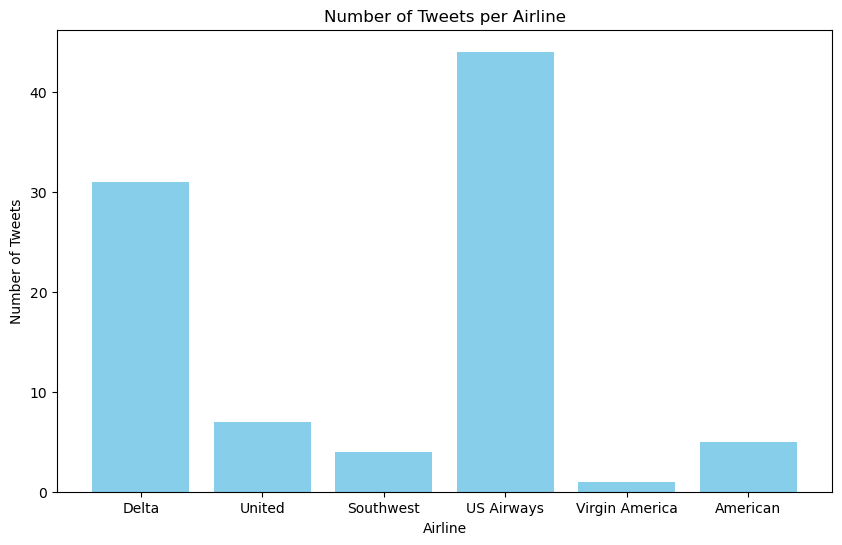

In [24]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df['airline'], df['retweet_count'], color='skyblue')
plt.title('Number of Tweets per Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.show()

This code creates a histogram to visualize the distribution of the 'negativereason_confidence' column in the DataFrame (df).

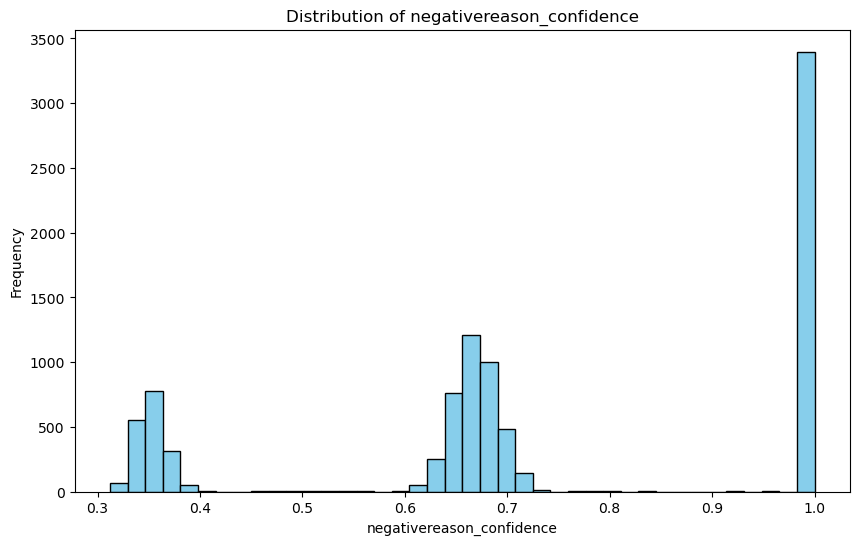

In [25]:
# Plotting the distribution of 'negativereason_confidence'
plt.figure(figsize=(10, 6))
plt.hist(df['negativereason_confidence'].dropna(), bins=40, color='skyblue', edgecolor='black')
plt.title('Distribution of negativereason_confidence')
plt.xlabel('negativereason_confidence')
plt.ylabel('Frequency')
plt.show()

Bayesian modeling each airline with positive binomial distribution

In [50]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'negativereason',
       'negativereason_confidence', 'retweet_count', 'airline', 'airline_id'],
      dtype='object')

This code snippet encodes the 'airline' column using LabelEncoder, defines a hierarchical Bayesian model using PyMC3, samples from the posterior distribution using MCMC, and finally plots the posterior distributions of selected parameters. It is a comprehensive approach to modeling the relationship between airline-specific features and negativereason_confidence and retweet_count using Bayesian techniques. 

### Model Evaluation

In [130]:
# Define the function for posterior predictive checks
def perform_ppc(trace, model, data):
    # Extract parameter values from the trace
    α_values = trace['α'][:]
    μ_values = trace['μ'][:]

    # Simulate data from the posterior predictive distribution
    simulated_data = np.random.negative_binomial(α_values, α_values / (α_values + μ_values), size=len(data))

    # Plot the observed and simulated data
    plt.hist(data, bins=30, alpha=0.5, label='Observed', color='blue')
    plt.hist(simulated_data, bins=30, alpha=0.5, label='Simulated', color='orange')
    plt.title('Posterior Predictive Checks')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [ ]:

# Retain only rows with values in 'negativereason_confidence' and 'airline'
df = df[(df['negativereason_confidence'].notnull()) & (df['airline'].notnull())]

# Convert categorical variables to integer
le_airline = preprocessing.LabelEncoder()
airlines_idx = le_airline.fit_transform(df['airline'])
airlines = le_airline.classes_
n_airlines = len(airlines)

indiv_traces = {}

for p in airlines:
    with pm.Model() as model_h:
        α = pm.Uniform('α', lower=0, upper=1.2)
        μ = pm.Uniform('μ', lower=0, upper=1)
        
        data = df[df['airline'] == p]['negativereason_confidence']
 
        y_est = pm.NegativeBinomial('y_est', mu=μ, alpha=α, observed=data)
        y_pred = pm.NegativeBinomial('y_pred', mu=μ, alpha=α)
        trace_h = pm.sample(2000, tune=2000)
        indiv_traces[p] = trace_h
        #perform_ppc(model_h, trace_h, data)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 41 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, μ]
>Metropolis: [y_pred]


In [95]:
airlines

array(['American', 'Delta', 'Southwest', 'US Airways', 'United',
       'Virgin America'], dtype=object)

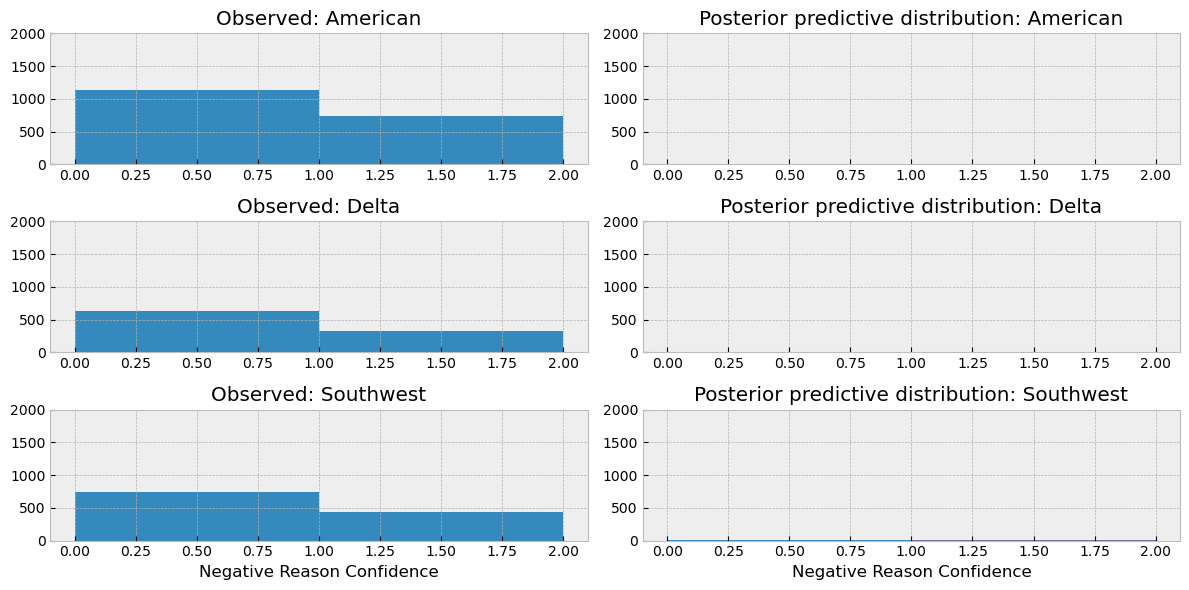

In [110]:
%matplotlib inline

colors = ['#D55E00', '#009E73', '#0072B2', '#348ABD', '#A60628', 
          '#7A68A6', '#467821', '#CC79A7', '#56B4E9', '#F0E442']

fig, axs = plt.subplots(3, 2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2000
y_right_max = 2000
x_lim = 2
ix = [0, 1, 2]

for i, j, p in zip([0, 1, 2], [0, 2, 4], airlines[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(df[df['airline'] == p]['negativereason_confidence'].values, range=[0, x_lim], bins=x_lim,
                histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0, 1, 2], [1, 3, 5], airlines[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].posterior['y_pred'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Negative Reason Confidence')
axs[5].set_xlabel('Negative Reason Confidence')

plt.tight_layout()


### Model Evaluation

In [114]:
import arviz as az
# Posterior Predictive Checks
with model_h:
    ppc = pm.sample_posterior_predictive(trace_h, samples=1000)

# Trace Summary
summary = pm.summary(trace_h)

# Gelman-Rubin Statistics
gelman_rubin = pm.gelman_rubin(trace_h)

# Plot Trace
pm.traceplot(trace_h)

# Plot Posterior Predictive Checks
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_h))

# Model Comparison (WAIC)
waic = pm.waic(trace_h, model=model_h)

# Display results
print("Trace Summary:")
print(summary)
print("\nGelman-Rubin Statistics:")
print(gelman_rubin)
print("\nWAIC:")
print(waic)

TypeError: sample_posterior_predictive() got an unexpected keyword argument 'samples'